In [17]:
import torch
import numpy as np
import cv2
from PIL import Image

In [18]:
import sys
sys.path.append('..')
from models import resnet50, densenet_121, resnet50_adv, resnet18, resnet18_seg, resnet18_dilate, resnet18_seg_dilate, EfficientNet, resnet18_g_l, ENet, resnet18_dilated, resnet18_ppm, resnet18_3tier, resnet18_layercat, resnet18_sematic, densenet_121_2classes
from utils import *

In [19]:
from collections import OrderedDict
checkpoint_path = '../checkpoints/my_data_v6_densenet121_2classes/04_21_15_40_fold_0_model_best.pth.tar'
model = densenet_121_2classes()
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','') # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [16]:
from collections import OrderedDict
checkpoint_path = '../checkpoints/my_data_v6_densenet121_transfer_480/04_21_17_28_fold_0_model_best.pth.tar'
model = densenet_121()
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','') # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [20]:
# 加载真实路面数据集
from dataset import MWD, MWD_Adv
from dataset import MyData, MyDataCS, MyDataSeg, MyData_2classes
from torchvision import transforms
import matplotlib.pyplot as plt             
import itertools

In [21]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]
# image_size = 224
# img_size = (576, 720)
img_size = (480, 480)
transform = transforms.Compose([
    # transforms.Resize((image_size, image_size)),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

# dataset = MWD(root_path="G:\\weather_recognition\\groud_truth", transform=transform)
# dataset = MWD_Adv(root_path="G:\\weather_recognition\\groud_truth", transform=transform)

# train_dataset = MyData(root_path=args.train_path, transform=train_transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v2\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_01_11\\", transform=transform)
# dataset = MyDataCS(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_01_11\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v4\\test\\", transform=transform)
# dataset = MyDataSeg(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v4\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v4\\test\\", transform=transform)
# dataset = MyDataSeg(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v5\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v5\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v6\\test\\", transform=transform)
# dataset = MyDataSeg(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v6\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\val_imgs\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\val_imgs_2\\", transform=transform)
# dataset = MyData_2classes(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v6\\test\\", transform=transform)
# dataset = MyData_2classes(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v6\\train\\", transform=transform)
dataset = MyData_2classes(root_path="G:\\vscode_workspace\\Weather_Recognition\\val_imgs_2\\", transform=transform)
# dataset = MyDataSeg(root_path="G:\\vscode_workspace\\Weather_Recognition\\val_imgs\\", transform=transform)

In [22]:
print(len(dataset))
print(dataset[0][0].shape)

440
torch.Size([3, 480, 480])


In [23]:
# img, true label, pred label 可视化

label_dict = {'cloudy': 0, 'haze': 1, 'rainy': 2, 'snow': 3, 'sunny': 4, 'thunder': 5}
label_list = ['cloudy', 'haze', 'rainy', 'snow', 'sunny', 'thunder']
def show_model_performance(images, labels, outputs, batch_idx=0):
    # print(images.shape, labels.shape, outputs.shape)
    _, figs = plt.subplots(1, 32, figsize=(96, 96))
    # print(len(figs))
    for f, img, lbl, pred in zip(figs, images, labels, outputs):
        img = np.transpose(img, (1, 2, 0))
        f.imshow(img)
        # print(lbl, pred)
        f.set_title(label_list[lbl] + ';' + label_list[pred[0]])
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    
    fig = plt.gcf()
    fig.savefig('figs/show_performance_' + str(batch_idx) + '.png', format='png', transparent=True)

    plt.show()

In [24]:
# 绘制混淆矩阵

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def compute_cm(cm, preds, labels):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        # if t == 2 and p == 1:
        #     print('miss!')
        # cm[p, t] += 1
        cm[t, p] += 1
    return cm

In [25]:
cnt = 0
def save_misclassify(inputs, targets, preds):
    global cnt
    save_dir = "misclassify_04_22_v6_densenet_transfer_val2//"
    label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']
    # label_list = ['Cloud/Sunny', 'Fog', 'Rainy', 'Snow']
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for img, t, p in zip(inputs, targets, preds):
        p = p[0]
        # print(img.shape, t, p)
        # break
        if t != p:
            img = np.transpose(img, (1, 2, 0))
            img = img * 255
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            # print(img.shape)
            img_path = save_dir + '{0}_{1}_{2}.jpg'.format(cnt, label_list[t], label_list[p]) 
            cv2.imwrite(img_path, img)
            cnt = cnt + 1


In [26]:
# 获取最后路面全连接层的特征
features_blobs = []
def hook_feature(module, inputs, outputs): # input是注册层的输入 output是注册层的输出
    # print("hook input",input[0].shape)
    # features_blobs.append(output)
    # print(inputs)
    features_blobs.append(inputs[0].data.cpu().numpy())
model.classifier.register_forward_hook(hook_feature)
label = []
sl_features = []

In [27]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

70.22727272727273
[[ 70.  29.]
 [102. 239.]]
Normalized confusion matrix
[[0.70707071 0.29292929]
 [0.29912023 0.70087977]]


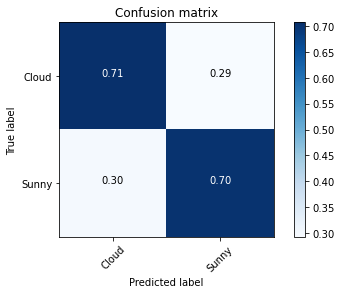

In [28]:
# 'cloudy': 0, 'haze': 1, 'rainy': 2, 'snow': 3, 'sunny': 4, 'thunder': 5
model = model.cuda()
model.eval()
top1 = AverageMeter()
# data_iter = torch.utils.data.DataLoader(dataset, 4, shuffle=False)
data_iter = torch.utils.data.DataLoader(dataset, 1, shuffle=False)

label = []
sl_features = []
features_blobs = []
# 混淆矩阵
# num_classes = 6
# label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']

num_classes = 2
label_list = ['Cloud', 'Sunny']

# num_classes = 4
# label_list = ['Cloud/Sunny', 'Fog', 'Rainy', 'Snow']


confuse_matrix = np.zeros([num_classes, num_classes])
# for batch_idx, (inputs, inputs_seg, targets) in enumerate(data_iter):
for batch_idx, (inputs, targets) in enumerate(data_iter):
    # inputs, inputs_seg, targets = inputs.cuda(), inputs_seg.cuda(), targets.cuda()
    inputs, targets = inputs.cuda(), targets.cuda()

    # features_blobs = []

    outputs = model(inputs)
    # outputs = model(inputs, inputs_seg)

    # print(outputs)
    _, pred = outputs.topk(1, 1)
    img = inputs[0].cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    hist_s = cv2.calcHist([img_hsv], [1], None, [256], [0.0, 255.0])
    hist_l = cv2.calcHist([img_lab], [0], None, [256], [0.0, 255.0])
    standardization(hist_s)
    standardization(hist_l)
    sl_features.append(np.concatenate((hist_s, hist_l), axis=0))
    label.append(targets.cpu().detach().numpy())
    # _, pred_2 = outputs.topk(2, 1)
    # for i, (a, b) in enumerate(pred_2):
    #     a, b = a.cpu().item(), b.cpu().item()
    #     if (a == 0 and b == 4) or (a == 4 and b == 0):
    #         model_prec_list.append((a, targets[i].cpu().item()))
    #         # print(len(features_blobs))
    #         # print(features_blobs[0].shape)
    #         svm_list.append((features_blobs[0][i], targets[i].cpu().item()))
    # print(pred)
    # print(targets)
    confuse_matrix = compute_cm(confuse_matrix, outputs, targets)
    prec = accuracy(outputs.data, targets.data, topk=(1,))
    top1.update(prec[0].item(), inputs.size(0))
    # save_misclassify(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
    # if batch_idx == 10:
    #     break
print(top1.avg)
print(confuse_matrix)
plot_confusion_matrix(confuse_matrix, label_list, normalize=True)
    # show_model_performance(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy(), batch_idx)
    # break

In [29]:
# print(len(sl_features))
# print(len(features_blobs))
sl_features = np.array(sl_features)
features_blobs = np.array(features_blobs)
label = np.array(label)
sl_features = sl_features.squeeze()
features_blobs = features_blobs.squeeze()
print(sl_features.shape, features_blobs.shape, label.shape)

(440, 512) (440, 1024) (440, 1)


In [30]:
label = label.squeeze()
print(label.shape)

(440,)


In [31]:
my_dict = {'sl_features': sl_features, 'features_blobs': features_blobs, 'labels': label}

In [32]:
# 保存模型
import pickle
save_path = "data_val_sl_512_densenet121_1024.pkl"
with open(save_path, 'wb') as pfile:
    pickle.dump(my_dict, pfile)

In [ ]:
# 'cloudy': 0, 'haze': 1, 'rainy': 2, 'snow': 3, 'sunny': 4, 'thunder': 5
model = model.cuda()
model.eval()
top1 = AverageMeter()
# data_iter = torch.utils.data.DataLoader(dataset, 4, shuffle=False)
data_iter = torch.utils.data.DataLoader(dataset, 4, shuffle=False)

svm_list = []
model_prec_list = []

# 混淆矩阵
# num_classes = 6
# label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']

num_classes = 5
label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny']

# num_classes = 4
# label_list = ['Cloud/Sunny', 'Fog', 'Rainy', 'Snow']


confuse_matrix = np.zeros([num_classes, num_classes])
# for batch_idx, (inputs, inputs_seg, targets) in enumerate(data_iter):
for batch_idx, (inputs, targets) in enumerate(data_iter):
    # inputs, inputs_seg, targets = inputs.cuda(), inputs_seg.cuda(), targets.cuda()
    inputs, targets = inputs.cuda(), targets.cuda()

    # features_blobs = []

    outputs = model(inputs)
    # outputs = model(inputs, inputs_seg)

    # print(outputs)
    _, pred = outputs.topk(1, 1)
    _, pred_2 = outputs.topk(2, 1)
    for i, (a, b) in enumerate(pred_2):
        a, b = a.cpu().item(), b.cpu().item()
        if (a == 0 and b == 4) or (a == 4 and b == 0):
            model_prec_list.append((a, targets[i].cpu().item()))
            # print(len(features_blobs))
            # print(features_blobs[0].shape)
            svm_list.append((features_blobs[0][i], targets[i].cpu().item()))
    # print(pred)
    # print(targets)
    confuse_matrix = compute_cm(confuse_matrix, outputs, targets)
    prec = accuracy(outputs.data, targets.data, topk=(1,))
    top1.update(prec[0].item(), inputs.size(0))
    # save_misclassify(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
    # if batch_idx == 10:
    #     break
print(top1.avg)
print(confuse_matrix)
plot_confusion_matrix(confuse_matrix, label_list, normalize=True)
    # show_model_performance(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy(), batch_idx)
    # break

In [25]:
# t sne 可视化
from sklearn.manifold import TSNE
print('Computing t-SNE embedding')
features_blobs = np.array(features_blobs)
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(features_blobs.reshape(792, -1))

Computing t-SNE embedding


In [29]:
label = []
for i in range(len(dataset)):
    label.append(np.array(dataset[i][1]))

In [42]:
print(len(label))
print(label[2])

792
0


No handles with labels found to put in legend.


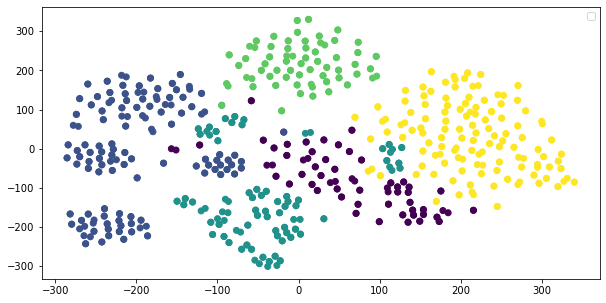

In [30]:
plt.figure(figsize=(10, 5))
# plt.subplot(121)
plt.scatter(result[:, 0], result[:, 1], c=label)
plt.legend()

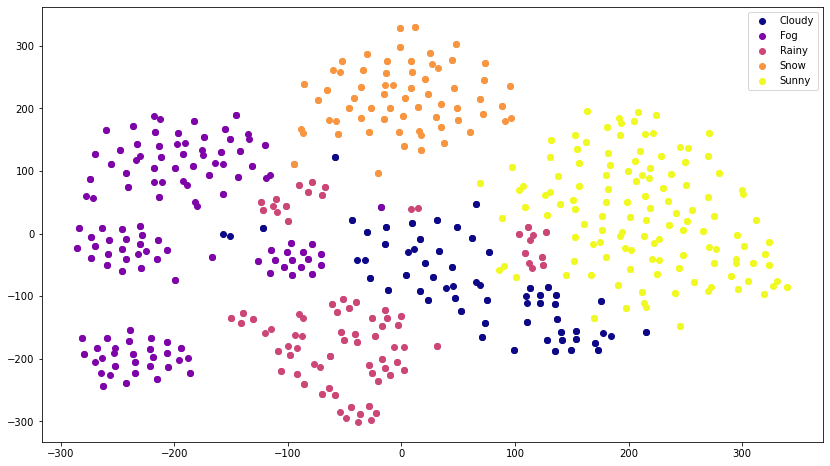

In [45]:
cmap = plt.get_cmap('plasma', 5) # 数字与颜色的转换
classes = [0, 1, 2, 3, 4]
classes_dict = {0: "Cloudy", 1: "Fog", 2: "Rainy", 3: "Snow", 4: "Sunny"}
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
label = np.array(label)
for key in classes:
    ix = np.where(label == key)
    # print(ix)
    ax.scatter(result[ix][:,0], result[ix][:,1], color=cmap(key), label=classes_dict[key])
ax.legend()


In [30]:
# print(model_prec_list)
# print(svm_list)
features = [x[0] for x in svm_list]
y = [x[1] for x in svm_list]
for i, v in enumerate(y):
    if v == 4:
        y[i] = 1
# y = svm_list[:, 1]
features = np.array(features)
features = features.reshape(-1, 512)

In [31]:
# model 的准确率
length = len(model_prec_list)
cnt = 0
for a, b in model_prec_list:
    if a == b:
        cnt += 1
print(cnt / length)

0.6885553470919324


In [32]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

In [33]:
with open("../postprocess/sunny_cloud_svm.pkl", "rb") as f:
    svc2 = pickle.load(f)

In [34]:
print(len(y))
print(len(features))
print(len(svm_list))
print(features[0].shape)

2132
2132
2132
(512,)


In [35]:
train_acc_svc = accuracy_score(svc2.predict(features), y)
# test_acc_svc = accuracy_score(svc.predict(x_test), y_test)
print(train_acc_svc)

0.7274859287054409


Normalized confusion matrix
[[0.24604013 0.19112988 0.00422386 0.11826822 0.43928194 0.00105597]
 [0.2556391  0.7443609  0.         0.         0.         0.        ]
 [0.35620915 0.00163399 0.49346405 0.         0.14869281 0.        ]
 [0.         0.         0.09274194 0.50403226 0.40322581 0.        ]
 [0.31603271 0.01528617 0.01564166 0.         0.651262   0.00177746]
 [0.         0.01992032 0.00796813 0.00398406 0.03187251 0.93625498]]


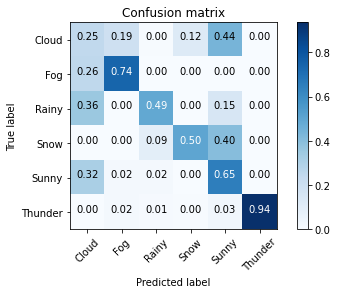

In [11]:
plot_confusion_matrix(confuse_matrix, label_list, normalize=True)

In [14]:
num_classes = 5
label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny']
confuse_matrix = [[0.63], [0.10], [0.002], [0.147], [0.112], ]



'../checkpoints/my_data_v3_densenet121/01_14_21_27_fold_0_model_best.pth.tar'